# Анализ посетителей торгового центра

# Задача
Есть таблица данных о посетителях торгового центра (столбцы: CustomerID, Genre, Age, Annual Income и Spending Score). Для улучшение бизнес-процессов и принятия стратегических решений нужно провести сегментацию клиентов, чтобы понять различия между группами покупателей. Также разработать рекомендации по маркетинговым мероприятиям.

# Порядок решения
Будем применять метод кластеризации, чтобы выделить несколько сегментов по возрасту, доходу и оценке расходов, что позволит лучше понять аудиторию ТЦ. Для этого пройдём следующие этапы:
- Провести анализ возрастных групп для получения представления о том, как разные поколения тратят свои деньги, чтобы правильно сформировать маркетинговые стратегии с учётом предпочтений этих групп. Например, если выяснится, что молодые люди с высоким уровнем дохода имеют высокую оценку расходов, то для них можно разрабатывать специальные предложения и акции.
- Установить взаимосвязи между доходами и расходами, чтобы выявить особенности покупательского поведения. Это может помочь в оптимизации ассортимента товаров, определении маржинальности и ценовой политики. 
- Провести анализ по полу клиентов, чтобы оценить, как различия между мужчинами и женщинами влияют на возрастные группы и расходы.
- Вывести сегменты клиентов по поведению, что позволит более эффективно направлять маркетинговые усилия и  создавать персонализированные рекламные кампании.

# Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings

# Игнорирование предупреждений FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# Загрузка данных
data = pd.read_csv("mall_visitors.csv")

# Предобработка данных
Напишем соответствующую функцию.

In [2]:
def preprocess_data(data, numeric_columns=None, categorical_columns=None, datetime_columns=None):
    """
    Функция предобработки данных:
    1) Приведение названий столбцов в общепринятый вид.
    2) Преобразование типов данных.
    3) Обработка пропущенных значений.
    4) Обработка выбросов с построением графиков.
    5) Обработка дубликатов.
    6) Удаление дробной части в числовых столбцах.
    
    :param data: Исходный DataFrame
    :param numeric_columns: Список числовых столбцов (опционально)
    :param categorical_columns: Список категориальных столбцов (опционально)
    :param datetime_columns: Список столбцов с датами (опционально)
    :return: Обработанный DataFrame
    """
    
    # Вывод информации о исходных данных
    print("Исходные данные:")
    print(data.head())
    print("\nИсходные пропуски:")
    print(data.isnull().sum())
    print("\nКоличество дубликатов:", data.duplicated().sum())
    
    # 1. Приведение названий столбцов в общепринятый вид
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    
    # 2. Преобразование типов данных
    if numeric_columns:
        # Приводим numeric_columns к нижнему регистру и заменяем пробелы на подчёркивания
        numeric_columns = [col.lower().replace(' ', '_') for col in numeric_columns]
        data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    if categorical_columns:
        # Приводим categorical_columns к нижнему регистру и заменяем пробелы на подчёркивания
        categorical_columns = [col.lower().replace(' ', '_') for col in categorical_columns]
        data[categorical_columns] = data[categorical_columns].astype('category')
    
    if datetime_columns:
        # Приводим datetime_columns к нижнему регистру и заменяем пробелы на подчёркивания
        datetime_columns = [col.lower().replace(' ', '_') for col in datetime_columns]
        for col in datetime_columns:
            data[col] = pd.to_datetime(data[col], errors='coerce')
    
    # 3. Обработка пропущенных значений
    if numeric_columns:
        for col in numeric_columns:
            data[col].fillna(data[col].median(), inplace=True)
    
    if categorical_columns:
        for col in categorical_columns:
            data[col].fillna(data[col].mode()[0], inplace=True)
    
    if datetime_columns:
        data.dropna(subset=datetime_columns, inplace=True)
    
    # Вывод информации о пропусках после обработки
    print("\nПропуски после обработки:")
    print(data.isnull().sum())
    
    # 4. Обработка выбросов
    if numeric_columns:
        # Создание subplot для boxplot'ов до обработки
        fig, axes = plt.subplots(1, len(numeric_columns), figsize=(15, 6))
        if len(numeric_columns) == 1:
          axes = [axes]
        for i, col in enumerate(numeric_columns):
            sns.boxplot(x=data[col], ax=axes[i])
            axes[i].set_title(f'До обработки - {col}')
        plt.suptitle('Boxplot до обработки выбросов')
        plt.tight_layout()
        plt.show()
            
        for col in numeric_columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Вывод количества выбросов
            outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
            print(f"Количество выбросов в столбце {col} до обработки: {len(outliers)}")
            
            data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
            data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
    
        # Создание subplot для boxplot'ов после обработки
        fig, axes = plt.subplots(1, len(numeric_columns), figsize=(15, 6))
        if len(numeric_columns) == 1:
          axes = [axes]
        for i, col in enumerate(numeric_columns):
            sns.boxplot(x=data[col], ax=axes[i])
            axes[i].set_title(f'После обработки - {col}')
            
            # Вывод количества выбросов после обработки
            outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
            print(f"Количество выбросов в столбце {col} после обработки: {len(outliers)}")

        plt.suptitle('Boxplot после обработки выбросов')
        plt.tight_layout()
        plt.show()


    
    # 5. Обработка дубликатов
    print("\nКоличество дубликатов до удаления:", data.duplicated().sum())
    data.drop_duplicates(inplace=True)
    print("Количество дубликатов после удаления:", data.duplicated().sum())
    
    # 6. Удаление дробной части в числовых столбцах
    if numeric_columns:
        for col in numeric_columns:
            data[col] = data[col].astype(int)  # Преобразуем в целые числа
    
    # Вывод информации о данных после обработки
    print("\nДанные после обработки:")
    print(data.head())
    print("\nОписание датафрейма:")
    print(data.info())
    print("\nОписательная статистика после обработки:")
    print(data.describe())
    
    return data

Исходные данные:
   CustomerID   Genre  Age  Annual Income  Spending Score
0           1    Male   19             15              39
1           2    Male   21             15              81
2           3  Female   20             16               6
3           4  Female   23             16              77
4           5  Female   31             17              40

Исходные пропуски:
CustomerID        0
Genre             0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

Количество дубликатов: 0

Пропуски после обработки:
customerid        0
genre             0
age               0
annual_income     0
spending_score    0
dtype: int64


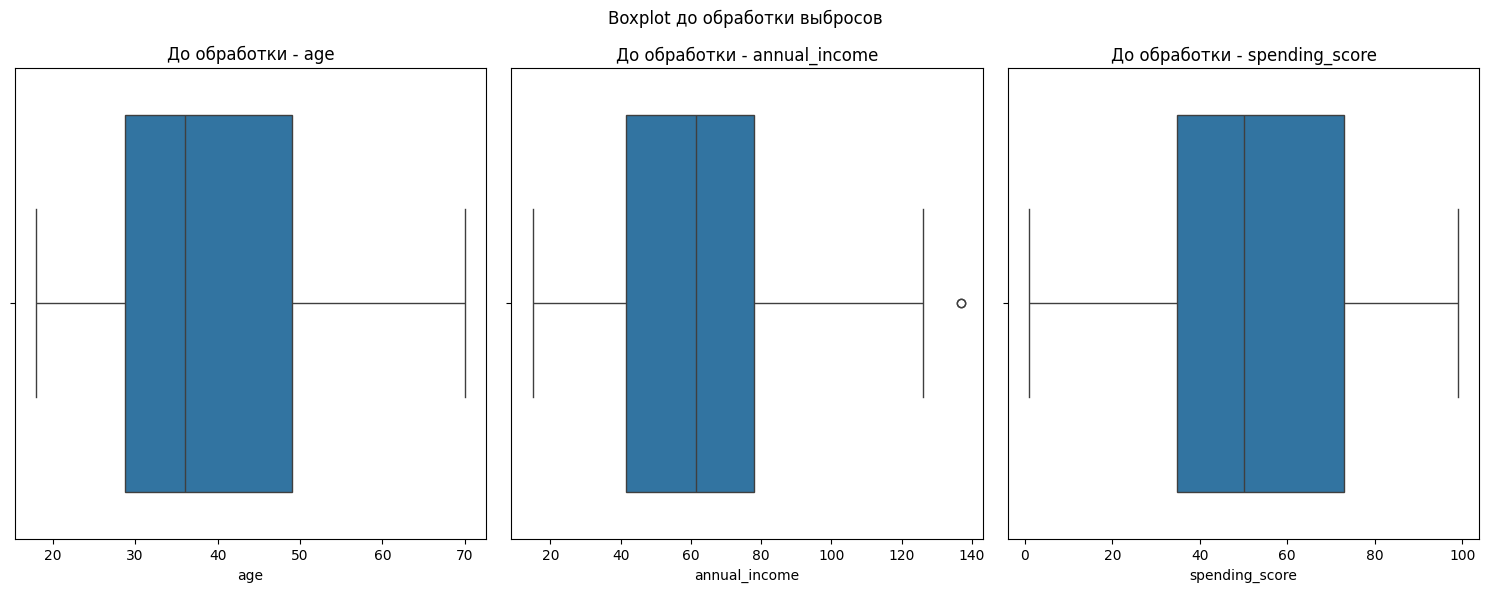

Количество выбросов в столбце age до обработки: 0
Количество выбросов в столбце annual_income до обработки: 2
Количество выбросов в столбце spending_score до обработки: 0
Количество выбросов в столбце age после обработки: 0
Количество выбросов в столбце annual_income после обработки: 2
Количество выбросов в столбце spending_score после обработки: 0


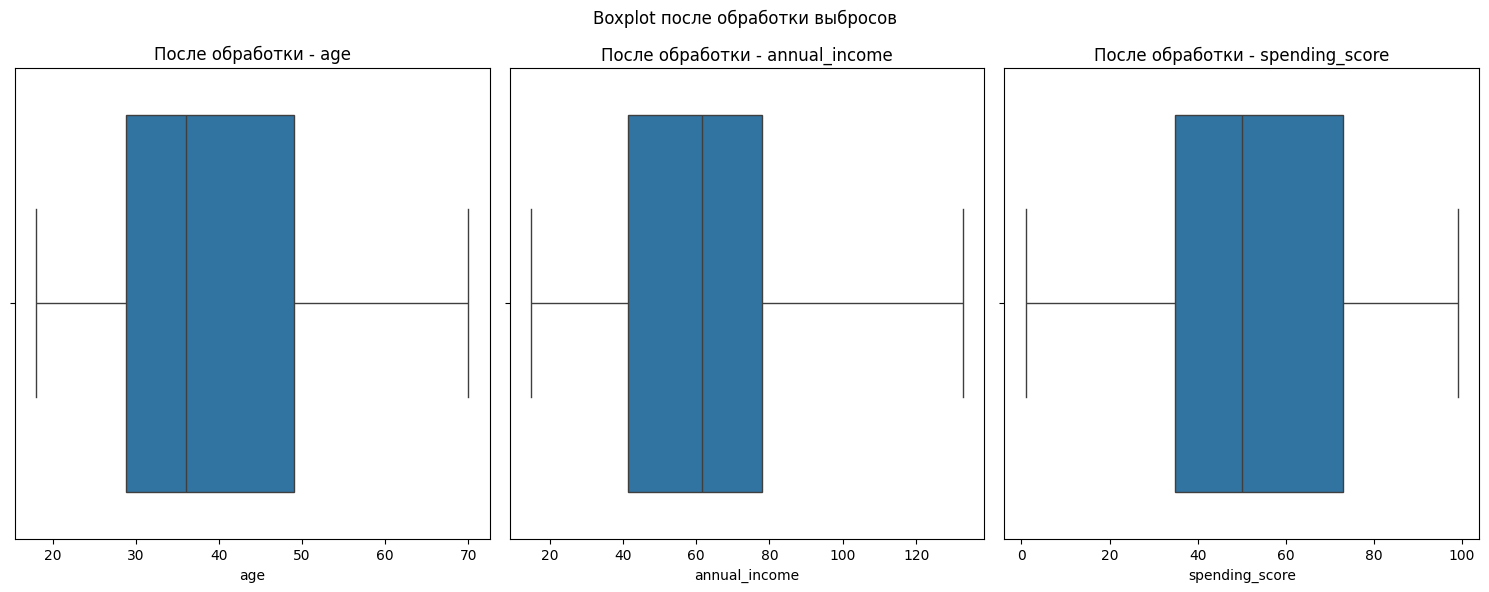


Количество дубликатов до удаления: 0
Количество дубликатов после удаления: 0

Данные после обработки:
   customerid   genre  age  annual_income  spending_score
0           1    Male   19             15              39
1           2    Male   21             15              81
2           3  Female   20             16               6
3           4  Female   23             16              77
4           5  Female   31             17              40

Описание датафрейма:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customerid      200 non-null    int64   
 1   genre           200 non-null    category
 2   age             200 non-null    int32   
 3   annual_income   200 non-null    int32   
 4   spending_score  200 non-null    int32   
dtypes: category(1), int32(3), int64(1)
memory usage: 4.4 KB
None

Описательная статистика после обра

In [3]:
# Очищаем данные
if __name__ == "__main__":
    df_data = pd.DataFrame(data)
    
    # Определяем типы столбцов
    numeric_columns = ['Age', 'Annual Income', 'Spending Score']
    categorical_columns = ['Genre']
#    datetime_columns = ['Date']
    
    # Применяем функцию предобработки
    df = preprocess_data(df_data, numeric_columns, categorical_columns)

Данный датафрейм представляет собой структурированный набор данных, содержащий информацию о 200 клиентах. В нём присутствует пять столбцов, каждый из которых описывает определенные параметры клиентов:
1. **customerid** - уникальный идентификатор клиента, представленный в формате целого числа (int64), варьируется от 1 до 200, что позволяет однозначно идентифицировать каждого клиента в наборе данных.
2. **genre** - указывает на пол клиентов и представлен как категориальная переменная. Данный формат позволяет эффективно обрабатывать данные клиентов, разделяя их на мужчин и женщин.
3. **age** -озраст клиентов представлен как целое число (int32), варьируются от 18 до 70 лет, что позволяет понять демографическую характеристику клиентов. Средний возраст составляет примерно 38.85 лет, значит в выборке представлены как молодёжь, так и более зрелые люди.
4. **annual_income** - доход клиентов также представлен в формате целого числа (int32). Диапазон доходов составляет от 15 до 132 единиц, со средним значением около 60.51. Эти данные могут помочь в дальнейшем анализе, связанном с покупательским поведением.
5. **spending_score** - этот столбец показывает, насколько активно клиенты тратят свои средства, представлен также в виде целого числа (int32). Значения колеблются от 1 до 99, со средним показателем в 50.20. Может использоваться для классификации клиентов по их покупательским привычкам и настраивания маркетинговых стратегий.

В соответствии с описательной статистикой, данные имеют следующие характеристики: общее количество записей по всем столбцам составляет 200, и все 200 значений в каждом столбце не содержат пропусков (Non-Null Count). Средние значения и стандартные отклонения для каждого из количественных признаков (возраст, доход и оценка расходов) дают возможность понять различные аспекты клиентского профиля. Например, стандартное отклонение по расходам достаточно велико (примерно 25.82), что указывает на значительное разнообразие в том, как клиенты тратят свои деньги. В целом, данный датафрейм является хорошей основой для дальнейшего анализа, направленного на понимание поведения клиентов и оптимизацию бизнес-процессов.

# Общий анализ
## 1. Расходы по возрастным группам

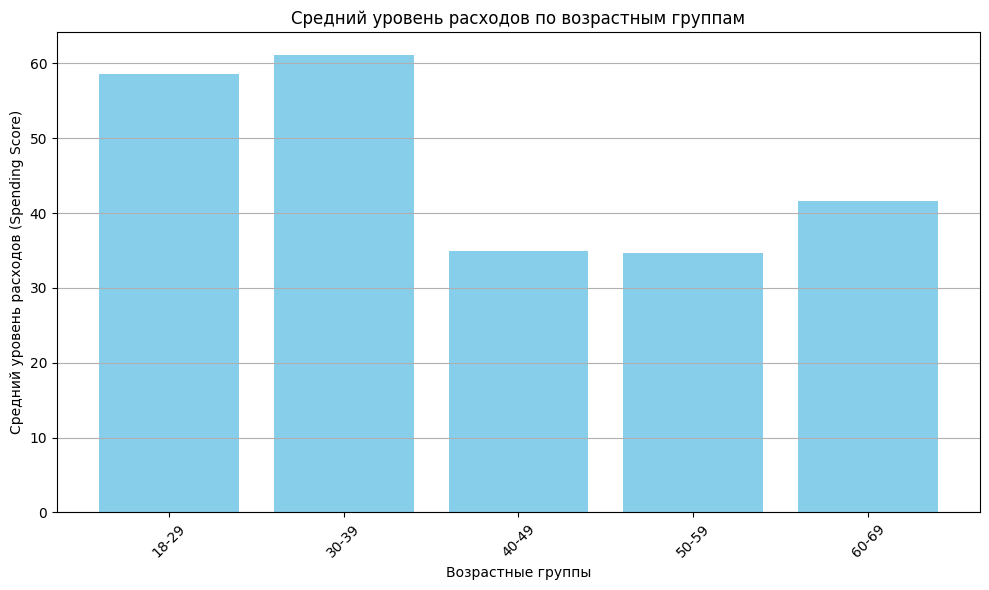

  age_group  spending_score
0     18-29       58.581818
1     30-39       61.098361
2     40-49       34.948718
3     50-59       34.720000
4     60-69       41.611111


In [4]:
# Определим возрастные группы
bins = [18, 30, 40, 50, 60, 70]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Вычислим средний уровень расходов для каждой возрастной группы
spending_summary = df.groupby('age_group')['spending_score'].mean().reset_index()

# Визуализируем результаты
plt.figure(figsize=(10, 6))
plt.bar(spending_summary['age_group'], spending_summary['spending_score'], color='skyblue')
plt.title('Средний уровень расходов по возрастным группам')
plt.xlabel('Возрастные группы')
plt.ylabel('Средний уровень расходов (Spending Score)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Показать график
plt.tight_layout()
plt.show()

# Выводим средние значения для анализа
print(spending_summary)

Каждая возрастная группа демонстрирует свои уникальные характеристики, что может быть полезно для маркетинговых стратегий и принятия бизнес-решений.

Начнем с группы **18-29 лет**, которая показывает средний уровень расходов (spending score) равный 58.58. Этот показатель говорит о том, что молодые люди в возрасте до 30 лет *более склонны к расходам* и могут тратить значительные суммы на развлечения, моду и технологии. Это может быть связано с поиском самовыражения, стремлением к статусу и активному использованию цифровых платформ для покупок.

Следующая группа, **30-39 лет**, имеет немного более высокий средний уровень расходов (61.10). То есть в этом возрасте люди, как правило, находятся на пике своей карьеры, *имеют стабильные источники дохода и более высокие потребительские возможности*. Они могут тратить деньги на улучшение качества жизни, путешествия и обеспечение своих семей.

Однако в группе **40-49 лет** наблюдается *резкое снижение среднего уровня расходов* до 34.95. Это может быть связано с тем, что в этот период жизни многие люди начинают более внимательно относиться к финансам, возможно, адаптируя свои расходы в связи с увеличением обязанностей, такими как забота о детях или поддержка пожилых родителей. Кроме того, это может быть возрастом, когда приоритеты смещаются к накоплению и сохранению финансов.

Аналогично, группа **50-59 лет** показывает ещё меньшее значение средних расходов — 34.72. В этом возрасте многие люди накапливают средства для выхода на пенсию и, возможно, *начинают сокращать свои расходы*, сосредотачиваясь на более необходимых покупках и экономии.

Наконец, в группе **60-69 лет** средний уровень расходов составляет 41.61. Этот возрастной сегмент может демонстрировать некоторое *восстановление в потребительских расходах*, возможно, благодаря пенсионным выплатам и накоплениям, которые позволяют некоторым людям тратить деньги на отдых, здоровье и развлечения.

В целом, эти результаты показывают, как возраст влияет на потребительское поведение. Каждая группа имеет свои уникальные характеристики, и это понимание может быть использовано для разработки таргетированных маркетинговых стратегий, а также для оптимизации продуктового ассортимента и улучшения сервиса для каждой целевой группы.

## 2. Расходы по полу

In [ ]:
# Группировка данных по полу и расчет среднего уровня расходов
gender_spending = df.groupby('genre')['spending_score'].mean().reset_index()
print(gender_spending)

# Визуализация среднего уровня расходов по полу
plt.figure(figsize=(8, 5))
sns.barplot(x='genre', y='spending_score', data=gender_spending, palette='pastel')
plt.title('Средний уровень расходов у посетителей разного пола')
plt.xlabel('Пол')
plt.ylabel('Средний уровень расходов')
plt.ylim(0, df['spending_score'].max() + 10)
plt.axhline(y=gender_spending['spending_score'].mean(), color='r', linestyle='--', label='Средний уровень расходов по всем')

# Обновление легенды, если объекты не отображаются
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels)

plt.show()

# Гистограмма расходов по полу
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='spending_score', hue='genre', multiple='stack', bins=20, palette='pastel')
plt.title('Распределение расходов по полу')
plt.xlabel('Уровень расходов')
plt.ylabel('Количество клиентов')

# Проверка и обновление легенды
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(title='Пол', loc='upper right', handles=handles, labels=labels)

plt.show()

Первый график показывает, что средний уровень расходов для женщин составляет примерно 51.53, в то время как для мужчин он равен 48.51. Это означает, что женщины имеют несколько более высокий в среднем уровень расходов по сравнению с мужчинами.

Второй график демонстрирует распределение расходов по полу (ось Х представляет собой уровень расходов, а ось У - количество клиентов, синие столбики показывают количество клиентов-мужчин, а оранжевые - количество клиентов-женщин). Гистограмма показывает, что среди клиентов-мужчин наблюдается большая концентрация клиентов с более высокими расходами.

### Возможные интерпретации результатов:

1. **Выраженное различие**: Разница в среднем уровне расходов между полами составляет приблизительно 3.02 единицы (51.53 - 48.51). Это может указывать на то, что женщины, более склонны тратить средства на определённые категории товаров или услуг, которые не учитываются в расходах мужчин, или же имеют другие приоритеты в расходах.

2. **Культурные факторы**: Различия в расходах могут быть вызваны культурными, социальными или экономическими факторами. Например, женщины могут больше тратить на одежду, косметику или услуги, в то время как мужчины могут делать акцент на другие категории.

3. **Психологические аспекты**: Исследования показывают, что мужчины и женщины могут подходить к покупкам и расходам с разными мотивациями. Женщины могут больше уделять внимание аспектам удовлетворённости от покупок или эмоциональным аспектам, что уменьшает их объективную экономическую составляющую.

4. **Необходимость более глубокого анализа**: Для понимания этих различий требуется более глубокий анализ, включая дополнительные данные, которые могут существенно повлиять на модели потребления и расходов.

5. **Визуализация результатов**: Рекомендуется также визуализировать данные, чтобы лучше понять распределение расходов внутри каждой группы. Это может помочь выявить возможные аномалии или паттерны в расходах, что дополнит количественные данные.

### Вывод:

Несмотря на то, что женщины в выборке имеют более высокий средний уровень расходов, важно учитывать контекст. Привлечение дополнительных данных и анализ поможет получить более полное понимание тенденций расходов между полами.

## 3. Анализ взаимосвязей между доходом и показателем расходов

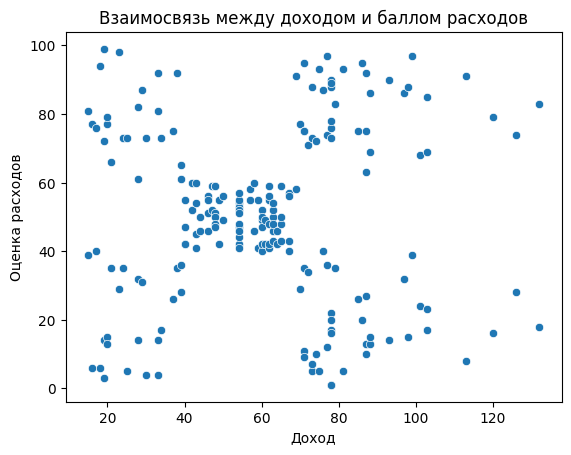

In [5]:
# Построим график рассеяния взаимосвязи между двумя переменными
sns.scatterplot(data=df, x='annual_income', y='spending_score')
plt.title('Взаимосвязь между доходом и баллом расходов')
plt.xlabel('Доход')
plt.ylabel('Оценка расходов')
plt.show()

Диаграмма рассеивания отражает взаимосвязь между доходами (ось x) и расходами (ось y) и показывает, что между ними существует положительная корреляция. То есть с увеличением дохода растут и расходы.

In [6]:
# Рассчитаем коэффициент корреляции Пирсона, который покажет степень линейной зависимости между доходом и показателем расходов
correlation = df['annual_income'].corr(df['spending_score'])
print(f'Коэффициент корреляции: {correlation}')

Коэффициент корреляции: 0.00993429208992524


Коэффициент корреляции равен примерно 0.01, что близко к 0 и указывает на то, что между доходом и показателем расходов практически нет линейной связи. Таким образом, можно сделать вывод, что изменения в одном из этих показателей не приводят к существенным изменениям в другом. То есть, знание годового дохода не даёт информации о том, как будут вести себя расходы посетителей.

Кроме того, стоит отметить, что даже при наличии низкой корреляции, могут существовать другие виды зависимостей (например, нелинейные связи), которые не учитываются в координации корреляции. Однако в нашем случае похоже, что линейная связь между рассмотренными переменными действительно отсутствует.

In [7]:
# Регрессионный анализ
X = df['annual_income']
y = df['spending_score']

X = sm.add_constant(X)  # Добавление константы для модели
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         spending_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.01954
Date:                Fri, 07 Feb 2025   Prob (F-statistic):              0.889
Time:                        12:39:31   Log-Likelihood:                -933.53
No. Observations:                 200   AIC:                             1871.
Df Residuals:                     198   BIC:                             1878.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            49.6058      4.628     10.718

### Общая информация

#### Обозначения:
- **Dep. Variable**: Это зависимая переменная `spending_score`.
- **Model**: Используемая модель — `OLS`, что означает метод наименьших квадратов (Ordinary Least Squares).
- **No. Observations**: Количество наблюдений в выборке 200.
  
### Основные статистические показатели

#### R-squared (R²)
- **R-squared**: Это мера качества подгонки модели. Наша модель имеет значение R-squared равное 0.000, то есть модель не объясняет варьирование зависимой переменной `spending_score`. Это означает, что доход не имеет никакого предсказательного значения для показателя расходов в вашей выборке.

#### Adj. R-squared (Скорректированное R²)
- **Adj. R-squared**: Скорректированное значение R², равное -0.005, указывает на то, что добавление независимой переменной в модель вообще ухудшает её подгонку.

### Статистика F
- **F-statistic**: Это статистика теста на значимость модели, которая равна 0.01954. Это очень низкое значение указывает на то, что модель незначительна.
- **Prob (F-statistic)**: Вероятность (p-value) для F-статистики равна 0.889, что значительно выше общего порога значимости (обычно 0.05). Это подтверждает, что переменная `annual_income` не является значимым предиктором для `spending_score`.

### Отношение между переменными

#### Коэффициенты
- **const (константа)**: Равен 49.6058 - означает, что при нулевом значении дохода средний показатель расходов составляет примерно 49.61.
- **annual_income**: Коэффициент равен 0.0098. Это значит, что при увеличении дохода на единицу (например, 1 рубль), показатель расходов (spending_score) увеличивается примерно на 0.0098, однако, эта связь незначима.

### Статистика t
- **t**-значения: Они показывают, насколько сильно независимые переменные влияют на зависимую переменную. Для `annual_income` t-значение составляет 0.140, указывает на то, что воздействие дохода на показатель расходов практически незначительно.
- **P>|t|**: p-value для дохода равен 0.889, указывает на то, что нельзя отвергнуть нулевую гипотезу о том, что коэффициент равен нулю (т.е. доход не имеет значимого эффекта на расходы).

### Диагностика модели
- **Omnibus тест**: Значение 16.460 с p-value 0.000 говорит о том, что данные о нормальности остатков могут быть неблагоприятными. Это важно учитывать при интерпретации результатов.
- **Durbin-Watson**: Значение 3.716 указывает на возможность автокорреляции остатков, так как оно значительно превышает значение 2. Это может свидетельствовать о том, что модель может не учитывать все значимые переменные.

## Заключение
Данные результаты указывают на то, что доход не имеет значительного влияния на показатель расходов в нашей модели. Значение R² равное 0.000 указывает на то, что модель почти не объясняет варьирование зависимой переменной - оценка расходов, и это может говорить о необходимости пересмотра модели: возможно, нужно включить другие значимые переменные или изменить метод анализа.

## 4. Анализ влияния пола клиентов на возрастные группы, доходы и оценку расходов

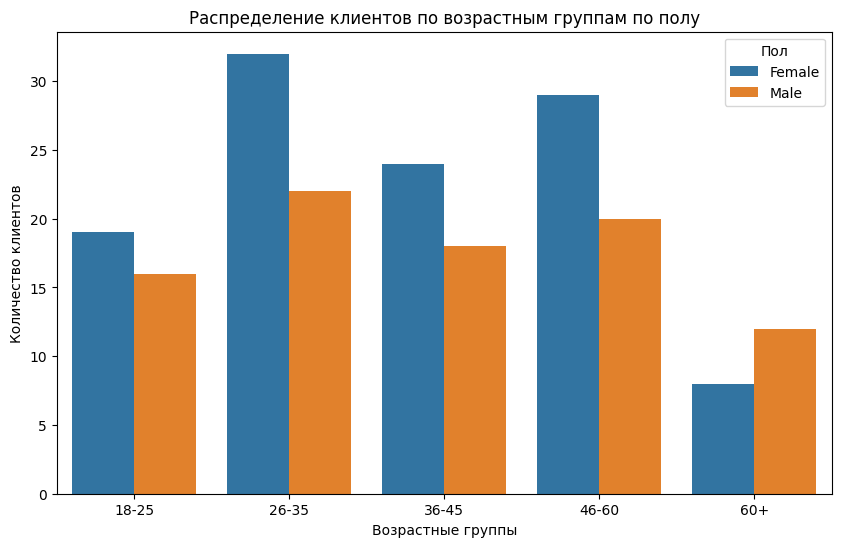

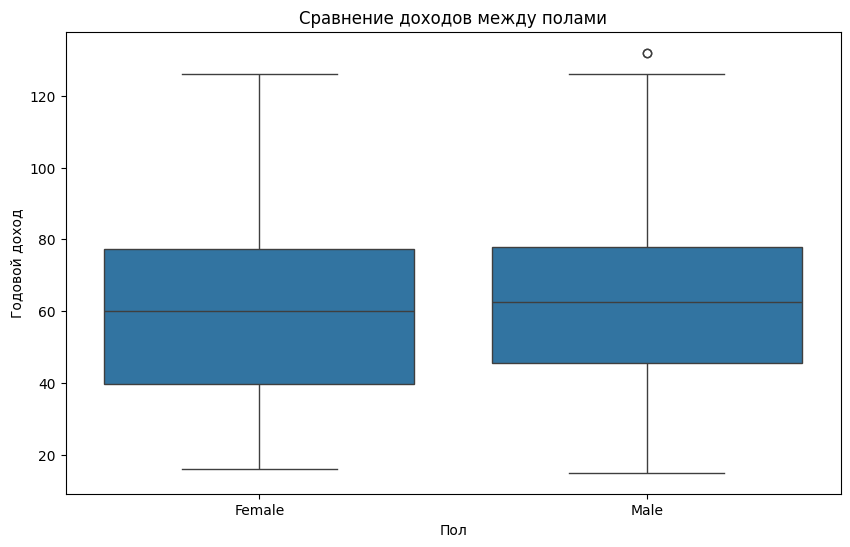

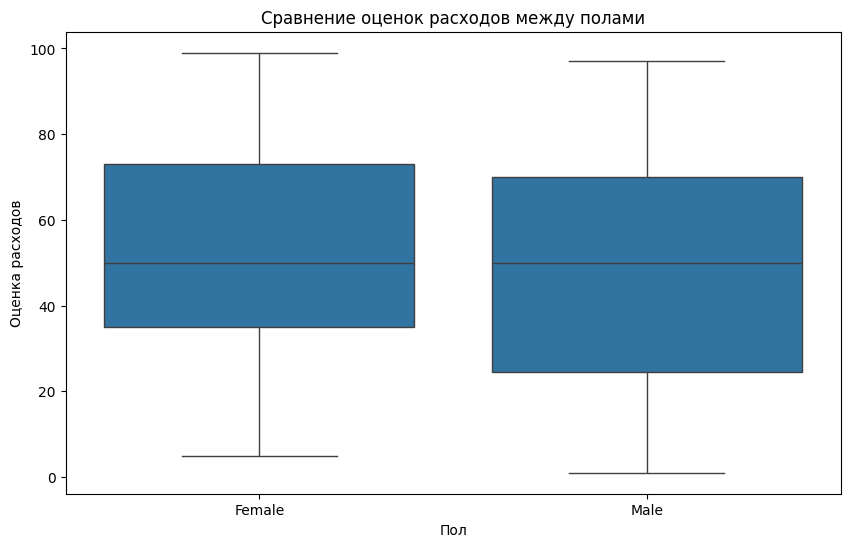

T-тест для доходов: Статистика t = 0.7676458137133789, p-значение = 0.44367142817478145
T-тест для оценок расходов: Статистика t = -0.8048781809684525, p-значение = 0.42199772447783646


In [8]:
# Анализ возрастных групп
bins = [18, 25, 35, 45, 60, 100]  # Определяем возрастные группы
labels = ['18-25', '26-35', '36-45', '46-60', '60+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Визуализация распределения по возрастным группам
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='genre', data=df)
plt.title('Распределение клиентов по возрастным группам по полу')
plt.xlabel('Возрастные группы')
plt.ylabel('Количество клиентов')
plt.legend(title='Пол')
plt.show()

# Сравнение доходов по полу
plt.figure(figsize=(10, 6))
sns.boxplot(x='genre', y='annual_income', data=df)
plt.title('Сравнение доходов между полами')
plt.xlabel('Пол')
plt.ylabel('Годовой доход')
plt.show()

# Сравнение оценок расходов по полу
plt.figure(figsize=(10, 6))
sns.boxplot(x='genre', y='spending_score', data=df)
plt.title('Сравнение оценок расходов между полами')
plt.xlabel('Пол')
plt.ylabel('Оценка расходов')
plt.show()

# Статистический анализ (например, t-тест для доходов)
from scipy import stats

male_income = df[df['genre'] == 'Male']['annual_income']
female_income = df[df['genre'] == 'Female']['annual_income']

t_stat, p_value = stats.ttest_ind(male_income, female_income, equal_var=False)
print(f'T-тест для доходов: Статистика t = {t_stat}, p-значение = {p_value}')

# Аналогично можно провести t-тест для оценок расходов
male_spending = df[df['genre'] == 'Male']['spending_score']
female_spending = df[df['genre'] == 'Female']['spending_score']

t_stat_spending, p_value_spending = stats.ttest_ind(male_spending, female_spending, equal_var=False)
print(f'T-тест для оценок расходов: Статистика t = {t_stat_spending}, p-значение = {p_value_spending}')

Первая гистограмма показала распределение клиентов по возрастным группам и полу. По оси x представлены возрастные группы, а по оси y - количество клиентов (синие столбики показывают количество клиентов-женщин, а оранжевые - клиентов-мужчин). На диаграмме видно, что в возрастных группах 26-35 и 36-45 лет больше женщин, а в возрастной группе 46-60 лет больше мужчин.

На втором графике сравниваются доходы женщин и мужчин. Медианный доход женщин немного ниже медианного дохода мужчин. График также показывает, что диапазон доходов женщин шире, чем у мужчин.

Третий график сравнивает баллы расходов женщин и мужчин. Медиана расходов для женщин немного ниже, чем медиана расходов для мужчин. График также показывает, что диапазон расходов для женщин шире, чем для мужчин.

В Т-тесте о доходах статистика t равна 0.7676458137133789, то есть средние значения доходов между двумя группами (двумя полами) отличаются незначительно. P-значение составляет 0.44367142817478145, что значительно больше стандартного уровня значимости 0.05. Это говорит о том, что мы не можем отвергнуть нулевую гипотезу, которая утверждает, что разницы в средних доходах между группами нет. В контексте этого теста, вывод заключается в том, что пол не оказывает значительного влияния на доходы.

Второй Т-тест об оценке расходов. Здесь статистика t равна -0.8048781809684525, что также может указывать на отсутствие значительной разницы между группами (полами). P-значение равно 0.42199772447783646, и снова это значение больше 0.05, что приводит к аналогичному выводу: недостаточно доказательств для отклонения нулевой гипотезы. То есть пол в этом случае также, скорее всего, не влияет на оценки расходов.

В общем и целом результаты обоих T-тестов указывают на то, что между полами нет статистически значимых различий ни в доходах, ни в оценках расходов. Это может свидетельствовать о равенстве этих параметров между исследуемыми группами. Важно отметить, что такое отсутствие значимости не обязательно означает, что нет различий вообще — возможно, они существуют, но исследуемых данных недостаточно для выявления этих различий или они очень маленькие.

## Выводы
Анализ данных показывает, что в возрастных группах 26-35 и 36-45 лет преобладают женщины, тогда как среди клиентов старше 46 лет мужчины становятся более многочисленными. В отношении доходов наблюдается, что медианный доход женщин ниже, чем у мужчин, с более широким диапазоном — это говорит о наличии как высоких, так и низких доходов среди женщин. Расходы демонстрируют аналогичную картину: медиана расходов для женщин также ниже. Широкий разброс в обоих показателях у женщин указывает на разнообразие их экономического поведения по сравнению с мужчинами.

# Детальный анализ

## 1. Кластеризация
Напишем функцию кластеризации посетителей торгового центра методом K-Means. Она должна содержать:
- Масштабирование признаков, чтобы они имели одинаковый диапазон значений (важно для алгоритма K-Means).
- Определение оптимального числа кластеров методами "локтя" и силуэтного анализа (Silhouette Score), построение графиков и ожидание ввода пользователем выбранного количества кластеров.
- Кластеризация алгоритмом K-Means.
- Визуализация кластеров на графике рассеяния.
- Вывод описательной статистики со средними значениями признаков для каждого кластера.
- Вывод количества наблюдений в каждом кластере.
- Статистика кластеров и количество наблюдений должны выводиться отдельно для мужчин и женщин.

In [9]:
def scale_features(df, columns_to_scale):
    """Масштабирование числовых признаков."""
    if not df.empty and len(columns_to_scale) > 0:
        scaler = StandardScaler()
        scaled_values = scaler.fit_transform(df[columns_to_scale])
        df_scaled = pd.DataFrame(scaled_values, columns=columns_to_scale, index=df.index)
        return df_scaled
    else:
        return pd.DataFrame()


def find_optimal_clusters(df, max_clusters=10, title_prefix=""):
    """Определение оптимального количества кластеров."""
    if not df.empty:
        inertia = []
        silhouette_scores = []
        for i in range(2, max_clusters + 1):
            kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
            kmeans.fit(df)
            inertia.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(df, kmeans.labels_))

        # Графики
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(2, max_clusters + 1), inertia, marker='o')
        plt.title(f'{title_prefix}Метод "локтя"')
        plt.xlabel('Количество кластеров')
        plt.ylabel('Инерция')
        plt.subplot(1, 2, 2)
        plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
        plt.title(f'{title_prefix}Силуэтный анализ')
        plt.xlabel('Количество кластеров')
        plt.ylabel('Силуэтный коэффициент')
        plt.tight_layout()
        plt.show()

        optimal_clusters = int(input(f"Введите оптимальное кол-во кластеров для {title_prefix.strip()}: "))
        return optimal_clusters
    else:
        return 0


def perform_kmeans_clustering(df, n_clusters):
    """Выполнение кластеризации K-Means."""
    if not df.empty and n_clusters > 0:
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
        y_kmeans = kmeans.fit_predict(df)
        return y_kmeans, kmeans
    else:
        return np.array([]), None


def visualize_clusters(df, y_kmeans, kmeans, title_prefix=""):
    """Визуализация кластеров."""
    if not df.empty and kmeans is not None and len(y_kmeans) > 0:
        plt.figure(figsize=(10, 6))
        unique_labels = np.unique(y_kmeans)
        for label in unique_labels:
            plt.scatter(df.iloc[y_kmeans == label, 0], df.iloc[y_kmeans == label, 1], label=f'Кластер {label}')
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black', marker='*',
                    label='Центроиды')
        plt.title(f'{title_prefix}Кластеры K-Means')
        plt.xlabel('Feature 1 (Age)')
        plt.ylabel('Feature 2 (Annual Income)')
        plt.legend()
        plt.show()


def describe_clusters(df, y_kmeans, gender_label):
    """Вывод описательной статистики."""
    if not df.empty and len(y_kmeans) > 0:
        df['cluster'] = y_kmeans
        print(f"\nОписательная статистика по кластерам ({gender_label}):")
        print(df.groupby('cluster').mean())
        df.drop('cluster', axis=1, inplace=True)


def print_cluster_counts(y_kmeans, gender_label):
    """Вывод количества наблюдений в каждом кластере."""
    if len(y_kmeans) > 0:
        unique, counts = np.unique(y_kmeans, return_counts=True)
        cluster_counts = dict(zip(unique, counts))
        print(f"\nКоличество наблюдений в кластерах ({gender_label}):")
        for cluster_id, count in cluster_counts.items():
            print(f"Кластер {cluster_id}: {count} наблюдений.")


def main():
    # Дублирование genre в числовом формате
    if 'genre' in df.columns:
      df['genre_numeric'] = df['genre'].astype('category').cat.codes
    else:
        df['genre_numeric'] = 0 # если нет genre столбца, то дефолтное значение
    
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    if 'genre_numeric' in numeric_columns:
        numeric_columns.remove('genre_numeric')

    df_male = df[df['genre_numeric'] == 1].copy()
    df_female = df[df['genre_numeric'] == 0].copy()

    df_scaled_male = scale_features(df_male, numeric_columns)
    df_scaled_female = scale_features(df_female, numeric_columns)

    optimal_clusters_male = 0
    optimal_clusters_female = 0
    y_kmeans_male = np.array([])
    y_kmeans_female = np.array([])
    kmeans_male = None
    kmeans_female = None

    if not df_scaled_male.empty:
        optimal_clusters_male = find_optimal_clusters(df_scaled_male, title_prefix="Мужчины ")
        if optimal_clusters_male > 0:
            y_kmeans_male, kmeans_male = perform_kmeans_clustering(df_scaled_male, optimal_clusters_male)

    if not df_scaled_female.empty:
        optimal_clusters_female = find_optimal_clusters(df_scaled_female, title_prefix="Женщины ")
        if optimal_clusters_female > 0:
           y_kmeans_female, kmeans_female = perform_kmeans_clustering(df_scaled_female, optimal_clusters_female)

    visualize_clusters(df_scaled_male, y_kmeans_male, kmeans_male, title_prefix="Мужчины ")
    visualize_clusters(df_scaled_female, y_kmeans_female, kmeans_female, title_prefix="Женщины ")

    describe_clusters(df_scaled_male, y_kmeans_male, "Мужчины")
    describe_clusters(df_scaled_female, y_kmeans_female, "Женщины")

    print_cluster_counts(y_kmeans_male, "Мужчины")
    print_cluster_counts(y_kmeans_female, "Женщины")

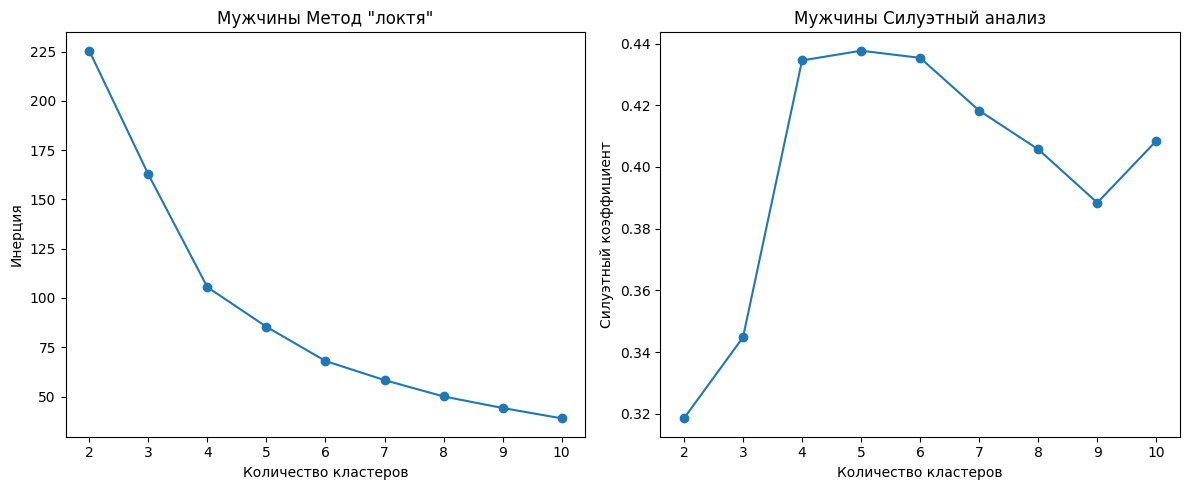

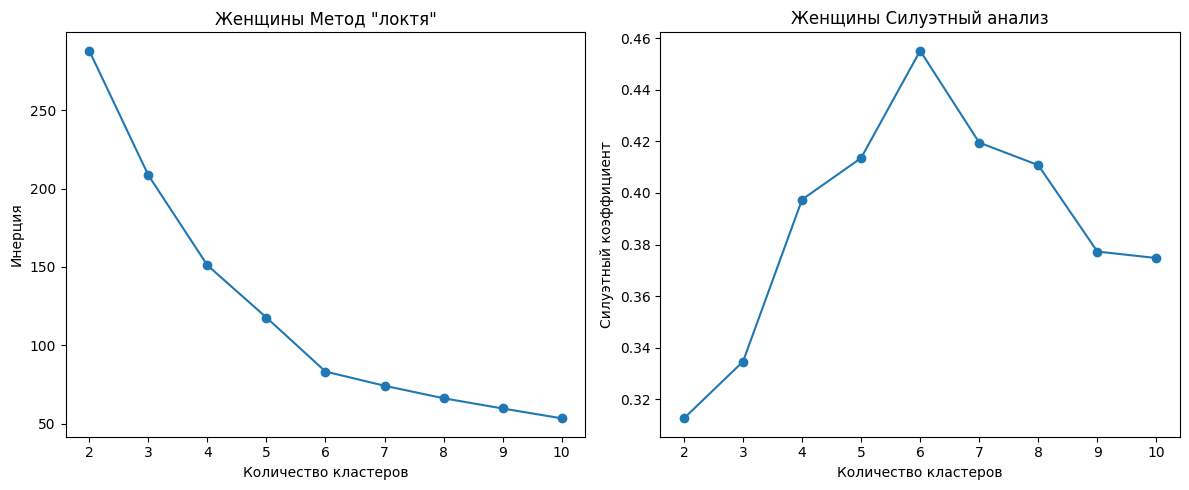

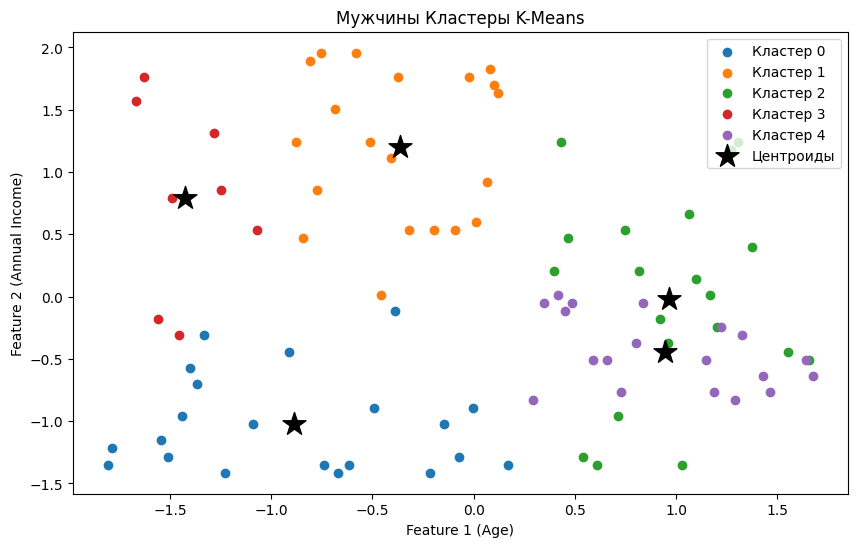

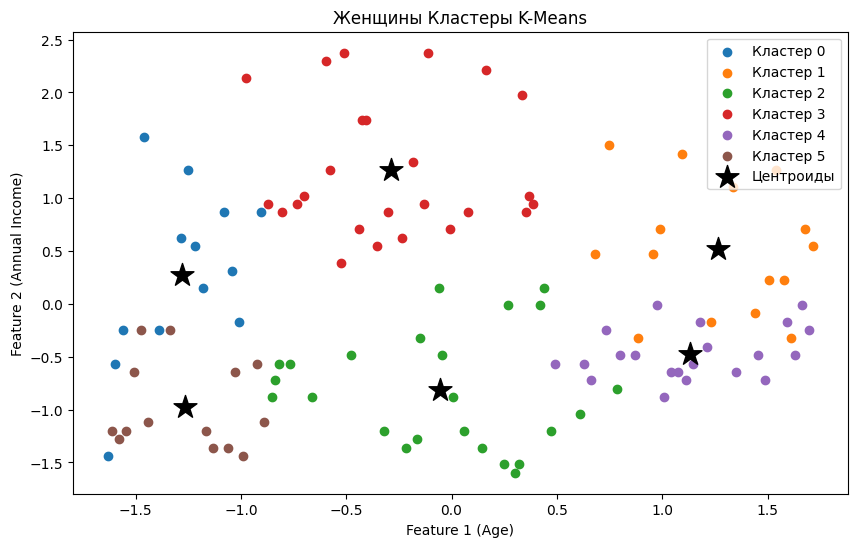


Описательная статистика по кластерам (Мужчины):
         customerid       age  annual_income  spending_score
cluster                                                     
0         -0.885635 -1.024660      -0.835760        0.522342
1         -0.366340  1.202041      -0.298522        0.023024
2          0.966847 -0.019889       0.870558       -1.242397
3         -1.425716  0.790410      -1.384505       -1.127031
4          0.947049 -0.444656       0.904541        1.180763

Описательная статистика по кластерам (Женщины):
         customerid       age  annual_income  spending_score
cluster                                                     
0         -1.277258  0.273306      -1.263210       -1.284392
1          1.265822  0.516526       1.277567       -1.246583
2         -0.054224 -0.815481      -0.043444       -0.207652
3         -0.288241  1.269653      -0.232086       -0.083592
4          1.133674 -0.469333       1.034834        1.255459
5         -1.263052 -0.972477      -1.259179    

In [10]:
if __name__ == "__main__":
    main()

## 2. Результаты кластеризации
### Общие замечания

*Количество кластеров* для мужчин и женщин **выбрано отдельно**.

*Масштабирование*: описательная статистика выводится для масштабированных данных, поэтому значения **не являются абсолютными**. Отрицательные значения означают, что среднее значение для этого кластера ниже среднего значения для всего набора данных, положительные - что выше. **Оценка расходов** (spending_score) показывает, насколько клиент склонен тратить деньги - высокое положительное значение означает, что клиент тратит больше среднего, а отрицательное – меньше.

---

### Описательная статистика
Кластеры показывают средние значения различных признаков для каждой группы после масштабирования данных.

#### Мужчины:

- **customerid**: Этот признак **не имеет особого значения** для интерпретации, так как он был отброшен при предобработке, но остался в данных. Мы можем его игнорировать.
- **age** (средний возраст):
     - Кластер 0: **значительно ниже среднего** (-1.024660). Мужчины в этом кластере относительно молодые.
     - Кластер 1: **значительно выше среднего** (1.202041). Это мужчины более старшего возраста.
     - Кластер 2: **очень близок к среднему** (-0.019889). Средний возраст.
     - Кластер 3: **выше среднего** (0.790410). Относительно старшего возраста.
     - Кластер 4: **ниже среднего** (-0.444656). Относительно молодые.
- **annual_income** (средний доход):
     - Кластер 0: **ниже среднего** (-0.835760). Имеют невысокий доход.
     - Кластер 1: **немного ниже среднего** (-0.298522). Имеют умеренный уровень дохода.
     - Кластер 2: **значительно выше среднего** (0.870558). Высокий доход.
     - Кластер 3: **значительно ниже среднего** (-1.384505). Имеют очень низкий доход.
     - Кластер 4: **значительно выше среднего** (0.904541). Имеют высокий доход.
- **spending_score** (средняя оценка расходов от 1 до 100 баллов):
     - Кластер 0: **выше среднего** (0.522342). Тратят относительно много.
     - Кластер 1: **близка к среднему** (0.023024). Тратят умеренно.
     - Кластер 2: **значительно ниже среднего** (-1.242397). Тратят значительно меньше, чем остальные.
     - Кластер 3: **значительно ниже среднего** (-1.127031). Мало очень тратят.
     - Кластер 4: **значительно выше среднего** (1.180763). Очень много тратят.

#### Женщины:

- **customerid**: Игнорируем этот признак.
- **age** (средний возраст):
     - Кластер 0: **немного выше среднего** (0.273306). Посетительницы среднего возраста.
     - Кластер 1: **выше среднего** (0.516526). Старше среднего возраста.
     - Кластер 2: **ниже среднего** (-0.815481). Относительно молодые.
     - Кластер 3: **значительно выше среднего** (1.269653). Старше среднего возраста.
     - Кластер 4: **ниже среднего** (-0.469333). Моложе среднего возраста.
     - Кластер 5: **ниже среднего** (-0.972477). Относительно молодые.
- **annual_income** (средний доход):
     - Кластер 0: **значительно ниже среднего** (-1.263210). Имеют низкий доход.
     - Кластер 1: **значительно выше среднего** (1.277567). Имеют высокий доход.
     - Кластер 2: **близок к среднему** (-0.043444). Имеют умеренный уровень дохода.
     - Кластер 3: **немного ниже среднего** (-0.232086). Имеют доход немного ниже среднего.
     - Кластер 4: **выше среднего** (1.034834). Имеют высокий доход.
     - Кластер 5: **значительно ниже среднего** (-1.259179). Имеют низкий доход.
- **spending_score** (средняя оценка расходов):
     - Кластер 0: **значительно ниже среднего** (-1.284392). Тратят очень мало.
     - Кластер 1: **значительно ниже среднего** (-1.246583). Также очень мало тратят.
     - Кластер 2: **ниже среднего** (-0.207652). Тратят немного меньше среднего.
     - Кластер 3: **немного ниже среднего** (-0.083592). Тратят немного меньше, чем в среднем.
     - Кластер 4: **значительно выше среднего** (1.255459). Тратят очень много.
     - Кластер 5: **значительно выше среднего** (1.150332). Очень много тратят.

---

### Количество наблюдений
Это показывает **количество посетителей**, попавших в каждый кластер.

- Кластер 0: 21 мужчина.
- Кластер 1: 20 мужчин.
- Кластер 2: 20 мужчин.
- Кластер 3: 8 мужчин.
- Кластер 4: 19 мужчин.
<br><br>
- Кластер 0: 13 женщин.
- Кластер 1: 15 женщин.
- Кластер 2: 24 женщины.
- Кластер 3: 25 женщин.
- Кластер 4: 21 женщина.
- Кластер 5: 14 женщин.

---

### Интерпретация результатов (с акцентом на поведение клиентов):

#### Мужчины:

- Кластер 0 (21 наблюдение): **“Молодые транжиры”** - это молодые мужчины с невысоким доходом, но с высокой склонностью к тратам. Возможно, они только начинают свою карьеру или являются студентами, и, несмотря на ограниченный бюджет, тратят достаточно много.
- Кластер 1 (20 наблюдений): **“Зрелые умеренные”** - это более зрелые мужчины с умеренным доходом и средними потребительскими привычками. Они могут быть более консервативны в своих тратах.
- Кластер 2 (20 наблюдений): **“Состоятельные бережливые”** - это мужчины со средним возрастом, но высоким доходом, которые, тем не менее, не склонны много тратить. Возможно, это клиенты, которые копят деньги или предпочитают более обдуманные покупки.
- Кластер 3 (8 наблюдений): **“Молодые с низким доходом и низкими расходами”** - это мужчины, которые, имея невысокий доход и являются бережливыми. Их относительно мало (всего 8) в наборе данных, что позволяет классифицировать их как “выбросы”.
- Кластер 4 (19 наблюдений): **“Молодые состоятельные транжиры”** - это молодые мужчины с высоким уровнем дохода, которые склонны тратить довольно много. Этот кластер можно рассматривать как ключевую целевую аудиторию.

#### Женщины:

- Кластер 0 (13 наблюдений): **“Молодые бережливые с низким доходом”** - молодые женщины с низким доходом, которые предпочитают экономить деньги. Их относительно мало (13) в наборе данных, что позволяет классифицировать их как “выбросы”.
- Кластер 1 (15 наблюдений): **“Состоятельные бережливые”** - это зрелые состоятельные женщины, которые предпочитают экономить деньги. Их относительно мало (15) в наборе данных, что также позволяет классифицировать их как “выбросы”.
- Кластер 2 (24 наблюдения): **“Зрелые умеренные”** - это относительно молодые женщины с умеренным доходом и умеренным уровнем расходов.
- Кластер 3 (25 наблюдений): **“Зрелые экономные”** - это зрелые женщины с доходом немного ниже среднего и не очень склонны к большим тратам.
- Кластер 4 (21 наблюдение): **“Молодые состоятельные транжиры”** - это молодые женщины с высоким доходом, которые склонны тратить довольно много. Являются ключевыми клиентами.
- Кластер 5 (14 наблюдений): **“Молодые транжиры с низким доходом”** - это молодые женщины с невысоким доходом, но при этом склонные к большим тратам. Их относительно мало (14) в наборе данных, что позволяет классифицировать их как “выбросы”.

---

## Промежуточные выводы

- *Разнообразие клиентов*: Видно, что есть значительное разнообразие среди клиентов по полу, возрасту, доходу и потребительскому поведению.
- *Выбросы*: Кластеры 3 у мужчин и кластеры 0, 1 и 5 у женщин могут быть рассмотрены как выбросы (**мало точек**).
- *Целевые аудитории*: Кластеры “Состоятельные транжиры” (как у мужчин, так и у женщин) могут быть **основной целевой аудиторией**, так как они обладают высоким доходом и высокой склонностью к тратам.
- *Возможности для персонализации*: На основе этих кластеров можно **создавать персонализированные предложения** и маркетинговые кампании.

Эти кластеры можно использовать для более точной сегментации клиентов, чтобы разработать персонализированные маркетинговые стратегии, а также для понимания поведения клиентов разного пола. Но для начала нужно изучить характеристики каждого кластера.
- Анализ средних признаков: изучение средних значений возраста, дохода и оценки расходов для каждого кластера.
- Визуализация: построение графиков, чтобы увидеть распределение признаков в каждом кластере.

## 3. Анализ средних

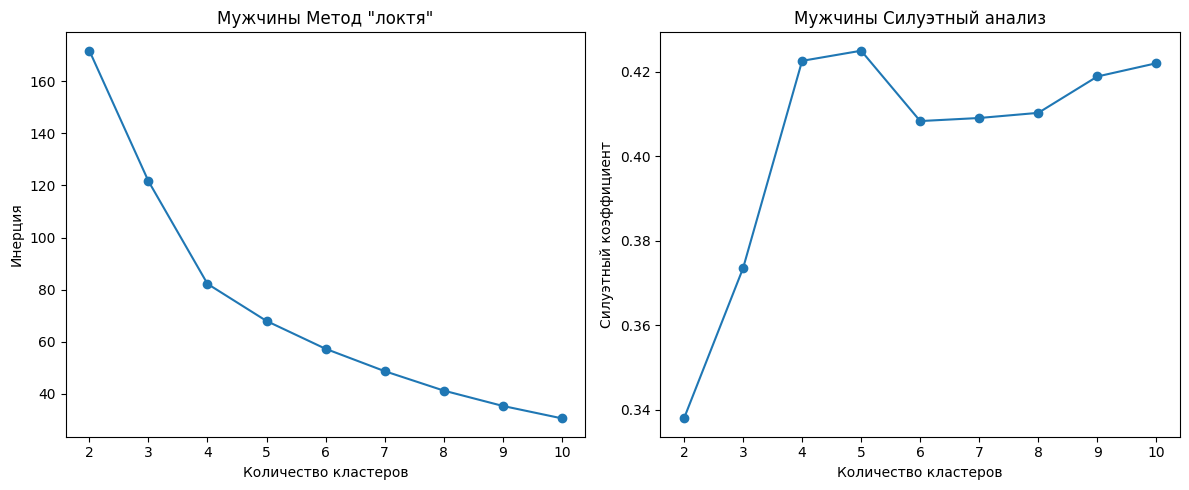

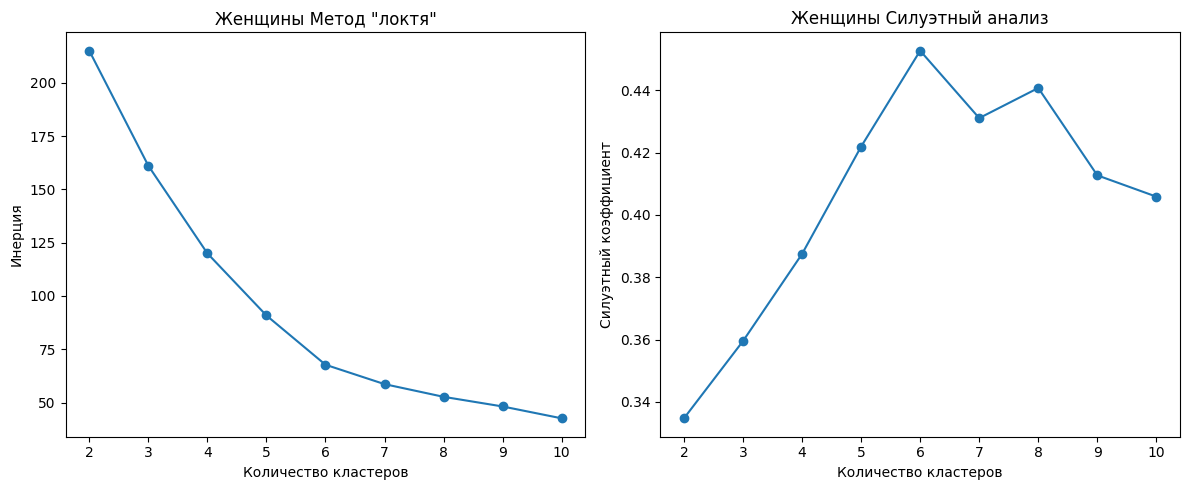

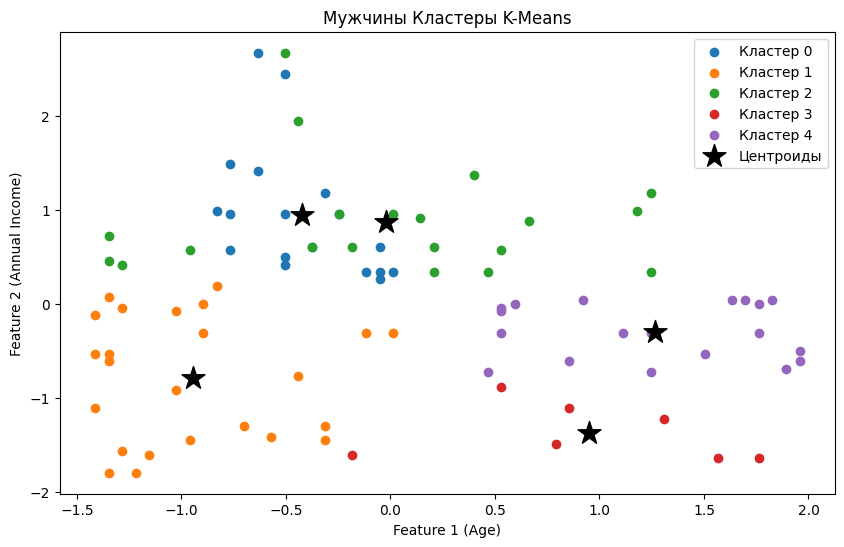

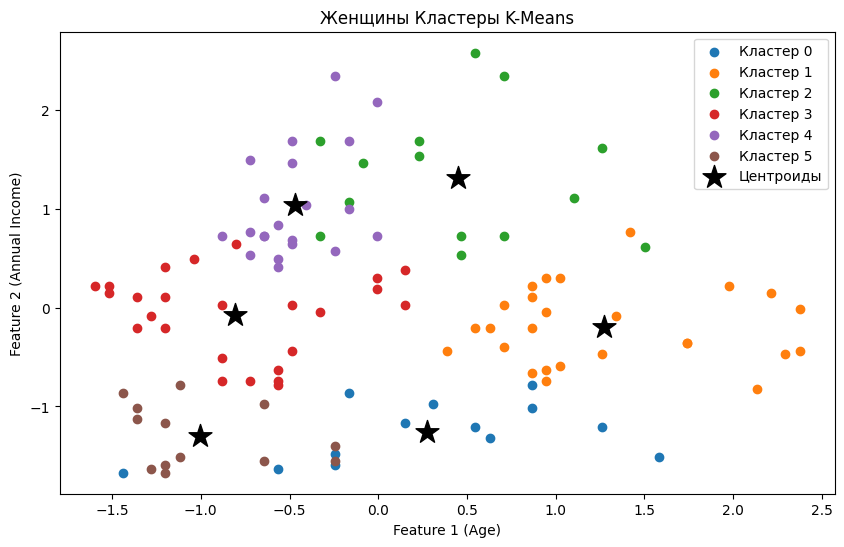


Описательная статистика по кластерам (Мужчины):
              age  annual_income  spending_score
cluster                                         
0       -0.423238       0.944422        1.231363
1       -0.943630      -0.797100        0.447234
2       -0.019889       0.870558       -1.242397
3        0.947839      -1.374272       -1.218448
4        1.264648      -0.297919        0.025206

Описательная статистика по кластерам (Женщины):
              age  annual_income  spending_score
cluster                                         
0        0.273306      -1.263210       -1.284392
1        1.275520      -0.193826       -0.106854
2        0.451836       1.314345       -1.286452
3       -0.805418      -0.072985       -0.183562
4       -0.469333       1.034834        1.255459
5       -1.003905      -1.295886        1.208465

Количество наблюдений в кластерах (Мужчины):
Кластер 0: 18 наблюдений.
Кластер 1: 24 наблюдений.
Кластер 2: 20 наблюдений.
Кластер 3: 7 наблюдений.
Кластер 4: 19 набл

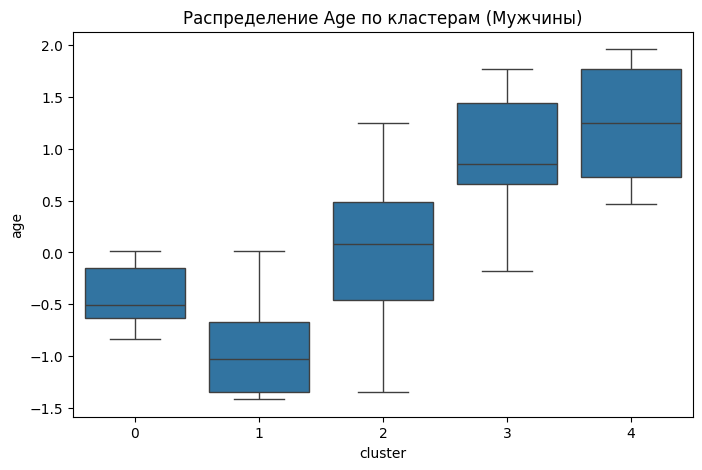

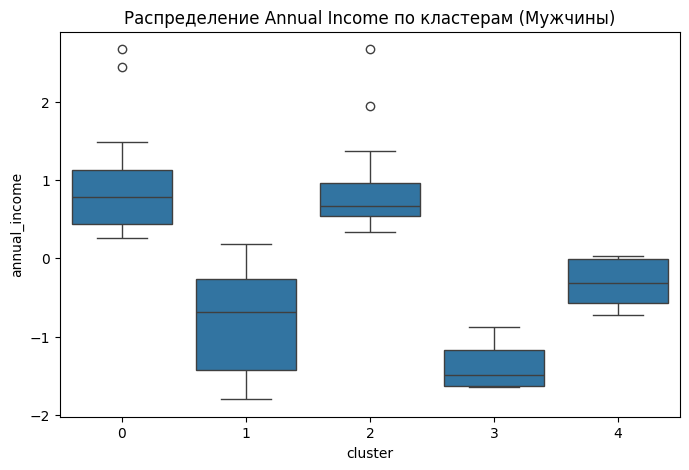

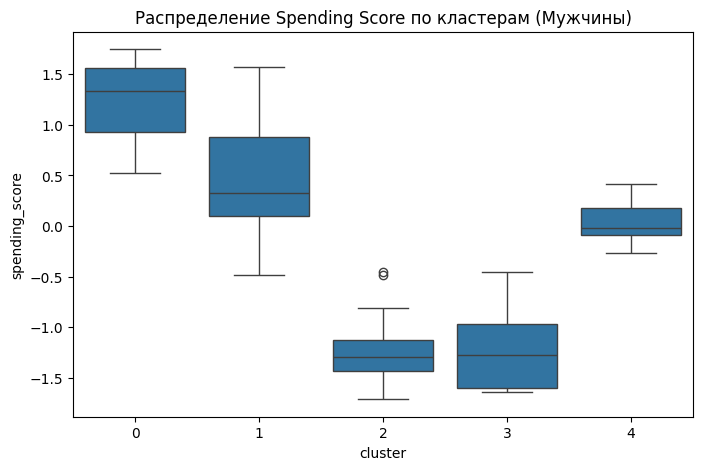


Средние значения признаков по кластерам (Женщины):
              age  annual_income  spending_score
cluster                                         
0        0.273306      -1.263210       -1.284392
1        1.275520      -0.193826       -0.106854
2        0.451836       1.314345       -1.286452
3       -0.805418      -0.072985       -0.183562
4       -0.469333       1.034834        1.255459
5       -1.003905      -1.295886        1.208465


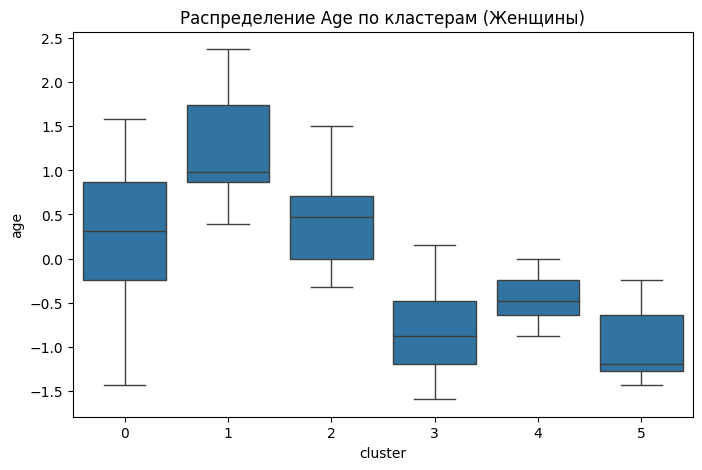

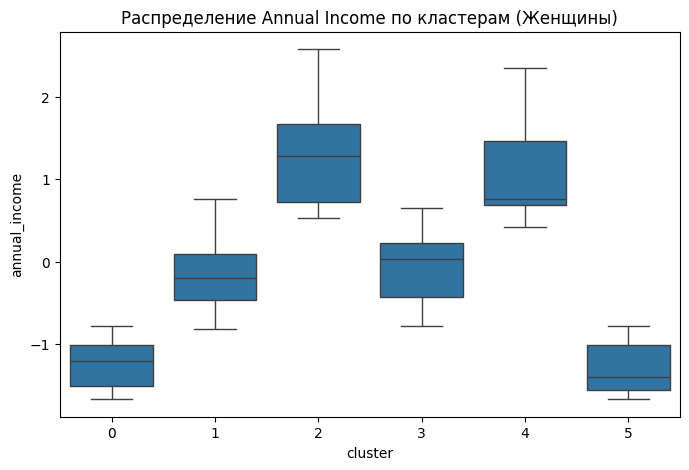

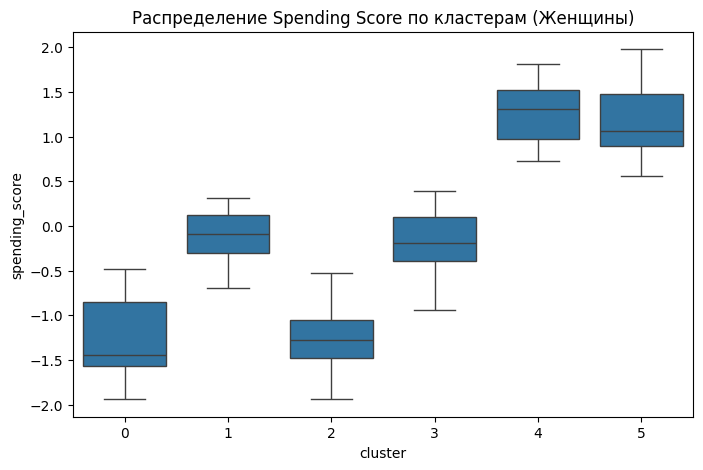

In [11]:
def analyze_cluster_features(df, y_kmeans, gender_label):
    """Анализ средних значений признаков для каждого кластера и их визуализация"""
    if not df.empty and len(y_kmeans)>0:
        df['cluster'] = y_kmeans
        
        # Средние значения
        print(f"\nСредние значения признаков по кластерам ({gender_label}):")
        cluster_means = df.groupby('cluster')[['age', 'annual_income', 'spending_score']].mean()
        print(cluster_means)
    
        # Визуализация
        for column in ['age', 'annual_income', 'spending_score']:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x='cluster', y=column, data=df)
            if column == 'spending_score':
                plt.title(f'Распределение Spending Score по кластерам ({gender_label})')
            elif column == 'annual_income':
                 plt.title(f'Распределение Annual Income по кластерам ({gender_label})')
            else:
                plt.title(f'Распределение Age по кластерам ({gender_label})')

            plt.show()

        df.drop('cluster', axis=1, inplace=True)

if __name__ == '__main__':
    if 'customerid' in df.columns:
        df.drop('customerid', axis=1, inplace=True)
    
    # Дублирование genre в числовом формате (вставьте ваш существующий код)
    if 'genre' in df.columns:
      df['genre_numeric'] = df['genre'].astype('category').cat.codes
    else:
      df['genre_numeric'] = 0
      
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    if 'genre_numeric' in numeric_columns:
        numeric_columns.remove('genre_numeric')
    
    # Разделение данных по полу (вставьте ваш существующий код)
    df_male = df[df['genre_numeric'] == 1].copy()
    df_female = df[df['genre_numeric'] == 0].copy()
    
    # Масштабирование (вставьте ваш существующий код)
    df_scaled_male = scale_features(df_male, numeric_columns)
    df_scaled_female = scale_features(df_female, numeric_columns)
    
    # Нахождение оптимального количества кластеров (вставьте ваш существующий код)
    optimal_clusters_male = 0
    optimal_clusters_female = 0
    y_kmeans_male = np.array([])
    y_kmeans_female = np.array([])
    kmeans_male = None
    kmeans_female = None
    
    if not df_scaled_male.empty:
        optimal_clusters_male = find_optimal_clusters(df_scaled_male, title_prefix="Мужчины ")
        if optimal_clusters_male > 0:
            y_kmeans_male, kmeans_male = perform_kmeans_clustering(df_scaled_male, optimal_clusters_male)

    if not df_scaled_female.empty:
        optimal_clusters_female = find_optimal_clusters(df_scaled_female, title_prefix="Женщины ")
        if optimal_clusters_female > 0:
            y_kmeans_female, kmeans_female = perform_kmeans_clustering(df_scaled_female, optimal_clusters_female)

    # Визуализация кластеров (вставьте ваш существующий код)
    visualize_clusters(df_scaled_male, y_kmeans_male, kmeans_male, title_prefix="Мужчины ")
    visualize_clusters(df_scaled_female, y_kmeans_female, kmeans_female, title_prefix="Женщины ")
    
    # Вывод описательной статистики (вставьте ваш существующий код)
    describe_clusters(df_scaled_male, y_kmeans_male, "Мужчины")
    describe_clusters(df_scaled_female, y_kmeans_female, "Женщины")
    
    # Вывод количества наблюдений в каждом кластере (вставьте ваш существующий код)
    print_cluster_counts(y_kmeans_male, "Мужчины")
    print_cluster_counts(y_kmeans_female, "Женщины")
    
    # Анализ признаков (новый вызов)
    analyze_cluster_features(df_scaled_male, y_kmeans_male, "Мужчины")
    analyze_cluster_features(df_scaled_female, y_kmeans_female, "Женщины")

## 4. Интерпретация результатов анализа средних
### Сегментация на основе полученных данных
Использовали 5 кластеров для мужчин и 6 кластеров для женщин по возрасту (`age`), доходу (`annual_income`) и уровню расходов (`spending_score`). Оба набора данных в стандартизированных величинах: значения признаков (возраст, доход, уровень расходов) сжаты к средним значениям (обычно среднее = 0 и стандартное отклонение = 1), что упрощает сравнение между кластерами. Количество наблюдений у мужчин распределяется по кластерам довольно равномерно, за исключением кластера 3, где меньше всего наблюдений (7 человек). Это может указывать на специфический набор характеристик, которые присущи небольшому числу представителей. У женщин наблюдается немного большее разнообразие, причем выделяется кластер 1, в который входит наибольшее количество наблюдений (26), и кластеры 0 и 5, где наблюдений всего по 13.

### Графики распределения
#### Мужчины
1. Средний возраст мужчин в кластере 4 самый высокий, за ним следуют кластер 3, кластер 2, кластер 0 и кластер 1; график также показывает, что разброс возрастов в кластере 4 шире, чем в других кластерах.
2. Медианный доход мужчин в кластере 0 самый высокий, за ним следуют кластер 2, кластер 4, кластер 1 и кластер 3. Разброс доходов в кластере 0 шире, чем в других кластерах.
3. На третьем графике видно, что мужчины из кластера 0 имеют самый высокий медианный показатель расходов, за ними следуют кластер 1, кластер 4, кластер 3 и, наконец, кластер 2.  Интересно отметить, что разброс показателей расходов шире в кластере 0 по сравнению с другими кластерами.
#### Женщины
1. На первом графике видно, что женщины в кластере 1 имеют самый высокий медианный возраст, за ними следуют кластер 0, кластер 2, кластер 4, кластер 3 и, наконец, кластер 5.  Интересно отметить, что разброс возраста шире в кластере 1 по сравнению с другими кластерами.
2. Женщины из кластера 2 имеют самый высокий медианный годовой доход, за ними следуют кластер 4, кластер 3, кластер 1, кластер 5 и, наконец, кластер 0. Интересно отметить, что разброс годовых доходов шире в кластере 2 по сравнению с другими кластерами.
3. Женщины из кластеров 4 и 5 имеют самые высокие медианные показатели расходов, за ними следуют кластер 3, кластер 1, кластер 2 и, наконец, кластер 0. Интересно отметить, что разброс показателей расходов шире в кластере 5 по сравнению с другими кластерами.

### Интерпретация среднего значения
#### Мужчины

1. **Кластер 0** (18 наблюдений): **“Состоятельные транжиры среднего возраста”**
   - Возраст: Средний возраст ниже среднего (-0.423238), может указывать на представителей поколения, стремящихся к новым потребительским привычкам. 
   - Доход: Доход выражен положительным стандартным отклонением (0.944422), то есть относительно высокий. Подразумевает, что эти мужчины, вероятно, находятся на стадии активного карьерного роста или работают в высокооплачиваемых отраслях.
   - Расходы: Уровень трат выше среднего (1.231363), что может говорить о склонности к роскоши и потреблению. Их высокий доход и молодость могут свидетельствовать о том, что они активно инвестируют в статусные вещи, что характерно для молодых профессионалов.

   Мужчины этого кластера моложе среднего возраста, имеют высокий доход и активно тратят деньги, больше, чем другие группы. Это кластер обеспеченных покупателей. Потенциальная стратегия маркетинга для этой группы может заключаться в предложении премиальных товаров и услуг, которые соответствуют их требованиям к качеству и имиджу.
   
2. **Кластер 1** (24 наблюдения): **“Неэкономная молодёжь с ограниченным бюджетом”**
   - Возраст: Значительно моложе среднего (-0.943630), является признаком более низкой финансовой устойчивости или начальной стадии карьеры.
   - Доход: Ниже среднего (-0.797100), эти мужчины начинают свой профессиональный путь или работают в менее прибыльных отраслях.
   - Расходы: Уровень трат немного выше среднего (0.447234), может свидетельствовать о рациональном подходе к деньгам. Эти мужчины, возможно, предпочитают тратить деньги на важные вещи, но при этом также ищут выгодные предложения.

   Молодые мужчины с низким доходом, но с умеренными или чуть выше средних расходами. Возможно, представители этого кластера не экономят, несмотря на ограниченные доходы. Эта группа может реагировать на маркетинг, ориентирующийся на молодёжные предложения и акции, а также на продукты, предлагающие соотношение цены и качества.

3. **Кластер 2** (20 наблюдений): **“Состоятельные экономные среднего возраста”**
   - Возраст: Близок к среднему (-0.019889), говорит о стабильности и устойчивом профессиональном развитии.
   - Доход: Выше среднего (0.870558), может указывать на высококлассных специалистов
   - Расходы: Очень низкие расходы (-1.242397), видимо, эти люди предпочитают сберегать и инвестировать свои средства.

   Мужчины среднего возраста с высоким доходом, но с низкими расходами. Это может быть результатом консервативного подхода к тратам (накопление или инвестиции вместо покупок). Эти мужчины, вероятно, ориентированы на серьёзные финансовые решения, такие как инвестиции в недвижимость или финансовые рынки. Для них подходят продукты, связанные с планированием будущего или инвестициями.

4. **Кластер 3** (7 наблюдений): **“Пожилые с низким доходом и низкими расходами”**
   - Возраст: Значительно старше среднего (0.947839), часто связан с задачами планирования пенсии или последними карьерными достижениями.
   - Доход: Очень низкий (-1.374272), мужчины этой группы могут либо иметь низкооплачиваемые профессии, либо уже быть на пенсии.
   - Расходы: Очень низкий уровень расходов (-1.218448) означает необходимость экономии.

   Пожилые мужчины с ограниченным доходом, которые сильно экономят (очень малочисленный кластер, возможно, выбросы). Эта группа может реагировать на маркетинг, предлагающий скидки на базовые потребительские товары. Стратегия, ориентированная на развитие услуг для пенсионеров или людей с ограниченными средствами, может хорошо сработать.

5. **Кластер 4** (19 наблюдений): **“Пожилые с умеренными расходами и низким доходом”**
   - Возраст: Старше среднего (1.264648), предполагает наличие некоторого жизненного опыта и стабильности, мужчины находятся на пике своей карьеры или в процессе перехода к более зрелому этапу жизни, где начинают осознавать важность финансового планирования и долговременных стратегий.
   - Доход: Немного ниже среднего (-0.297919), эти люди либо находятся на менее оплачиваемых должностях, либо работают в отраслях с более низкими зарплатами. Также может быть связано с индивидуальными обстоятельствами, такими как выбор карьерного пути или отсутствие возможностей для продвижения.
   - Расходы: Близки к средним значениям (0.025206), эти мужчины более осмотрительны в своих финансах, могут уделять внимание планированию бюджета, избегая излишних трат и предпочитая продукцию и услуги, которые обеспечивают хорошее соотношение цена-качество, чтобы более эффективно управлять своим финансами даже при ограниченных доходах.

   Пожилые мужчины с доходом немного ниже среднего, у которых практически средние по объёму расходы. Могут быть заинтересованы в продуктах и услугах, которые помогают оптимизировать их расходы, а также товарах высокого качества и долговечных по разумной цене, независимо от брендов.

#### Женщины
1. **Кластер 0** (13 наблюдений): **“Бережливые среднего возраста с низким доходом”**
   - Возраст: Немного выше среднего (0.273306), находятся на ранних этапах своей карьеры, возможно, продолжают учёбу. Это предполагает наличие высокого уровня амбиций и стремление к карьерному росту.
   - Доход: Очень низкий доход (-1.263210), многие женщины этого кластера либо только начинают свою карьеру, либо ещё учатся. Неопределённость в финансовом положении может подталкивать этих женщин к более экономному поведению.
   - Расходы: Очень низкий уровень трат (-1.284392), наверное, предпочитают вкладывать в своё образование, более сознательно подходить к финансам в условиях ограниченных возможностей.

   Женщины немного старше среднего возраста, с очень низким доходом и крайне ограниченным уровнем потребления. Предполагается, что они активны в социальных сетях и используют их для поиска возможностей, что открывает новые пути для маркетинга, ориентированного на цифровые платформы. Могут реагировать на предложения с сохранением бюджета: скидки, продвижение недорогих товаров, возможность гибких платежей, аксессуары, которые подчеркивают индивидуальность на фоне ограниченного бюджета.

2. **Кластер 1** (26 наблюдений): **“Пожилые и экономные с низким доходом”**
   - Возраст: Значительно старше среднего (1.275520), эти женщины обычно уже имеют взрослых детей и существенный жизненный опыт, находятся в более стабильной жизненной ситуации.
   - Доход: Немного ниже среднего (-0.193826), их карьера, возможно, уже заканчивается, поэтому доходы незначительны.
   - Расходы: Уровень трат близок к средним (-0.106854), может указывать на экономный подход, связанный с необходимостью поддерживать семью или уровень жизни, который они считают приемлемым, в условиях ограниченного дохода.

   Пожилые женщины с чуть ниже среднего доходом и практически средними расходами. Стараются управлять бюджетом. Могут быть чувствительны к ценам на продукты и услуги, и, соответственно, заинтересованы в акциях или эксклюзивных предложениях. Им также могут быть интересны гибкие условия оплаты.

3. **Кластер 2** (14 наблюдений): **“Взрослые состоятельные и экономные”**
   - Возраст: Немного выше среднего (0.451836), находятся в активной жизненной фазе и в расцвете своей карьеры.
   - Доход: Высокий доход (1.314345) предполагает их успешность в карьере (достигли профессиональных успехов) или наличие высокооплачиваемой работы.
   - Расходы: Очень низкие расходы (-1.286452), предпочитают сберегать свои финансы или инвестировать их. Возможно, они ориентированы на долгосрочные цели, такие как приобретение недвижимости или накопления на раннюю пенсию.

   Женщины среднего возраста с высоким доходом, но экономным подходом к потреблению. Могут реагировать на предложения по облегчению управления личными финансами. Также направление wellness, подобно спа-процедурам, может вызывать их интерес.

4. **Кластер 3** (25 наблюдений): **“Молодые со средними доходами и расходами”**
   - Возраст: Значительно младше среднего (-0.805418), находятся на начальных стадиях карьеры, но успешных, или же активно использовали возможности, доступных в цифровом пространстве, таких как фриланс или стартапы. 
   - Доход: Немного ниже среднего (-0.072985), возможно, не имеют значительных финансовых обязательств или являются начинающими специалистами, может не устроились на постоянную работу.
   - Расходы: Немного ниже среднего (-0.183562), может также говорить о том, что они наслаждаются своим финансовым положением, возможно, вкладывая деньги в путешествия, занятия спортом или досуг.

   Молодые женщины с доходами и расходами немного ниже среднего, что может указывать на начальный этап финансовой независимости или ограничение денежных средств. Могут ориентироваться на качество жизни и личное развитие.

5. **Кластер 4** (21 наблюдение): **“Молодые состоятельные транжиры”**
   - Возраст: Немного младше среднего (-0.469333), включает женщин, которые развивают свою карьеру, возможно уже завели семью и имеют детей, что стало стимулом для развития в своей профессии.
   - Доход: Высокий доход (1.034834) говорит о том, что в данный момент эти женщины находятся на пике своей карьеры.
   - Расходы: Очень высокий уровень трат (1.255459), стремятся наслаждаться жизнью и пользуются своим финансовым положением, возможно, часто путешествуют.

   Молодые женщины с доходами выше среднего, которые стремятся к высокому качеству жизни, следят за модными трендами и здоровым образом жизни. Они принимают во внимание новинки и могут очень быстро реагировать на маркетинг в социальных сетях, ориентированном на органические и натуральные продукты.

6. **Кластер 5** (13 наблюдений): **“Молодые транжиры с низким доходом”**
   - Возраст: Значительно младше среднего (-1.003905), эти женщины, возможно, пережили значительные изменения в своей жизни, такие как разводы или перемены в карьере. Они могут стремиться к самоидентификации и личному развитию.
   - Доход: Очень низкий доход (-1.295886) говорит о том, что изменения в жизни были негативными и связаны также с финансами.
   - Расходы: Высокий уровень трат (1.208465), ведут себя как потребители с высоким уровнем расходов, ориентируются на удовлетворение своих потребностей, несмотря на финансовые ограничения, возможно, из-за импульсивного финансового поведения или влияния социальных факторов, давления со стороны сверстников.

   Очень молодые женщины с крайне низким доходом, но с активным уровнем расходов. Возможно, речь идет о молодых потребителях, которые полагаются на внешние источники доходов (например, помощь от родителей или кредитные средства). В маркетинге важно создать пространство для поддержки и вдохновения. Предложения, направленные на восстановление уверенности, общение в соцсетях способствующее обмену опытом.

#### Итоговая структура сегментов
Сегменты выделены по возрасту, уровню доходов и склонности к тратам. Поведение в сегментах варьируется от бережливого до потребительски активного, независимо от уровня доходов. Меньшие кластеры (например, кластер 3 у мужчин или кластер 5 у женщин) могут подразумевать специфические исключения или потенциальные аномалии данных. Сегменты могут быть охарактеризованы также по интересам и поведенческим паттернам. Наиболее коммерчески перспективные сегменты включают в себя женщин средних лет и молодых с высоким доходом (например, Кластеры 2 и 4), а также мужчин, находящихся на пике своей карьеры (Кластеры 0 и 2).

### Промежуточные выводы
1. Мужчины и женщины распределены в соответствии с возрастом, доходом и уровнем расходов, что позволяет выделить молодые, средние и пожилые группы с разными финансовыми позициями. 
2. У мужчин больше кластеров с менее активным потреблением (2, 3 и 4), что может отражать общий прагматизм или склонность к накоплению в некоторых возрастных группах.
3. У женщин больше кластеров с ярко выраженными расходами (например, кластеры 4 и 5), несмотря на возможные ограничения в доходах.
4. Наибольший уровень расходов характерен для молодых и финансово обеспеченных групп обоих полов, тогда как минимальный уровень трат — для пожилых с низкими доходами.  

Анализ демонстрирует, как различные группы людей могут быть использованы для построения маркетинговых стратегий. Например, на молодежь с высокой склонностью к расходам даже при низком доходе можно нацеливать рекламные кампании с рассрочкой или скидками. Состоятельные покупатели с умеренными расходами требуют более доступной и практичной рекламы товаров премиум-класса. Пожилые люди с низкими доходами заслуживают упоминания акций и эксклюзивных предложений, что отвечает их ожиданиям от доступной экономики.

# Заключение
## Общие рекомендации
Это поможет разработать эффективные маркетинговые стратегии для каждого сегмента, что приведёт к увеличению продаж и улучшению лояльности клиентов. Но это лишь общие рекомендации, поэтому следует адаптировать их под конкретные особенности бизнеса и клиентов.
- Анализ поведенческих данных - анализировать данные о покупках (частота, средний чек, виды товаров), чтобы понять поведение клиентов в каждом сегменте.
- Использовать дополнительные данные - если есть другие данные (например, данные о посещении сайта, участии в акциях), анализировать их для каждого сегмента.
- Изучение причин - попробовать изучить причины поведения, возможно, это особенности возрастной группы, или особенности предпочтений, связанные с социальным статусом.
- Многоканальный маркетинг - надо использовать различные каналы для коммуникации с клиентами (e-mail, SMS, социальные сети, реклама в интернете).
- Персонализированные сообщения - Необходимо адаптировать связь под особенности каждого сегмента.
- Тестирование и анализ - обязательно регулярно тестировать различные маркетинговые стратегии и анализировать их эффективность.
- Обратная связь - общение с клиентами для улучшения предложений.
- Динамическое ценообразование - предлагая скидки для разных сегментов, менять цены в режиме реального времени в зависимости от различных факторов: текущих рыночных условий, спроса, поведения клиентов, и т. п.
- A/B-тестирование - проводить A/B-тестирование для определения наиболее эффективных сообщений и каналов для каждого сегмента.
- Отслеживание результатов - изучать результаты кампаний, чтобы оценить эффективность и внести коррективы.
- Гибкость - готовность адаптировать свои стратегии в зависимости от изменений в поведении клиентов и рыночных условиях.

## Маркетинговые мероприятия для привлечения и удержания
Примеры персонализированных стратегий:
- Предложения продуктов:
     - Молодые транжиры: предлагать товары по привлекательным ценам, акции, модные новинки.
     - Состоятельные бережливые: предлагать товары премиум-класса, эксклюзивные предложения.
     - Зрелые умеренные: указывать на качественные товары среднего ценового сегмента, с акцентом на функциональность.
- Маркетинговые сообщения:
     - Молодые транжиры: использовать яркие и запоминающиеся сообщения, ориентированные на тренды.
     - Состоятельные бережливые: использовать сообщения, подчеркивающие качество, долговечность и эксклюзивность.
     - Зрелые умеренные: рассылать сообщения, акцентирующие на практичность и удобство.
- Каналы коммуникации:
     - Молодые транжиры: активно использовать социальные сети, мобильные приложения, email-маркетинг.
     - Состоятельные бережливые: применять email-маркетинг, персональные консультации, VIP-сервис.
     - Зрелые умеренные: использовать email-маркетинг, SMS-рассылки, информационные материалы.
- Ценообразование:
     - Молодые транжиры: предлагать скидки, рассрочки, кредитные линии.
     - Состоятельные бережливые: извещать о высоких ценах, но с акцентом на эксклюзивность и качество.
     - Зрелые умеренные: предлагать конкурентоспособные цены, с возможностью участвовать в программе лояльности.

### Перспективные коммерческие сегменты

1. **Женщины с высоким доходом (Кластеры 2 и 4)**: Эти потребители обычно ищут качественные товары и услуги, такие как мода, здоровье, спорт и отдых. Они также более открыты к инвестициям в себя. Существует возможность предложить им эксклюзивные продукты, услуги, а также premium-сегмент товаров.

2. **Мужчины в возрасте 30-45 лет (Кластер 0)**: Эти мужчины стремятся к успеху в карьере и жизни, что делает их идеальными клиентами для товаров и услуг, связанных с улучшением работоспособности, профессиональным ростом и образом жизни. Они могут быть заинтересованы в технологиях, фитнесе и путешествиях. Также можно предложить товары из premium-сегмента.

Для коммерчески перспективных сегментов можно разработать следующие маркетинговые мероприятия:

- **Персонализированный контент**: Создание контента, который соответствует интересам и потребностям конкретных сегментов. Например, позитивные истории женщин из Кластеров 2 и 4, связанные с нашим ТЦ, или советы для мужчин из Кластера 0 о том, что есть интересного.

- **Программы лояльности**: Вознаграждение клиентов за повторные покупки: может включать скидки, эксклюзивные предложения или доступ к уникальному продукту.

- **Социальные медиа и Influencer Marketing**: Использование смежных отраслей и влияние персонажей в соцсетях, чтобы продвигать товары и услуги. Важно найти подходящих инфлюенсеров, которые резонируют с этой аудиторией и вызвали у ней доверие.

- **Мероприятия и вебинары**: Проведение тематических вебинаров или живых мероприятий, где целевая аудитория может узнать больше о продуктах и услугах, а также получить полезную информацию. Это может создать чувство сообщества и доверия к ТЦ.

### Перспективы и возможности использования других сегментов

Каждый из оставшихся сегментов также может найти свою нишу. Например:

- **Молодёжь**: В силу своей высокой активности в социальных сетях, может стать основным каналом для вирусного маркетинга и маркетинга на основе рефералов. Игровые механики и креативные конкурсы могут быть эффективными методами привлечения этой аудитории.

- **Посетители среднего возраста**: Для этого сегмента можно сфокусироваться на здоровье и благосостоянии, предлагая продукты и услуги, которые помогут им поддерживать активный и здоровый образ жизни. Марткетинговые мероприятия могут включать создание цифровых сообществ, помощь в получении положительного опыта, а также интересные для них приложения.

- **Пожилые мужчины и женщины**: Этот сегмент может быть заинтересован в более традиционных продуктах и услугах, которые облегчают повседневную жизнь. Подход может включать организацию местных мероприятий по использования новых продуктов и технологий.

Таким образом, выделяя коммерчески перспективные сегменты и разрабатывая специфические маркетинговые мероприятия для их привлечения и удержания, вы сможете значительно увеличить свои шансы на успех в конкурентной среде. Каждый сегмент имеет свои уникальные особенности, и успешная стратегия должна учитывать эти различия для достижения наилучшего результата.

### Примеры целевых кампаний
- Для “Молодых транжир”:
     - Сообщения: “Самые горячие тренды сезона!” “Распродажа, которую ты не можешь пропустить!”
     - Креативы: Яркие, динамичные изображения, с участием модных инфлюенсеров.
     - Каналы: Социальные сети (Instagram, TikTok), мобильная реклама, email-рассылки с акциями.
- Для “Состоятельных бережливых”:
     - Сообщения: “Надежность, проверенная временем”, “Премиум качество по разумной цене”.
     - Креативы: Сдержанные изображения, акцент на качестве и долговечности.
     - Каналы: Email-маркетинг, личные приглашения на эксклюзивные мероприятия, качественные буклеты с описанием.
- Для “Зрелых умеренных”:
     - Сообщения: “Практично, удобно, выгодно”, “Товары для комфортной жизни”.
     - Креативы: Изображения с акцентом на удобство и функциональность.
     - Каналы: Email-маркетинг, SMS-рассылки, реклама в интернете на сайтах новостей.
- Для “Состоятельных транжир”:
     - Сообщения: “Будь первым!”, “Эксклюзивные предложения для избранных”, “Побалуй себя!”
     - Креативы: Шикарные, стильные изображения, акцент на премиальности.
     - Каналы: VIP-сервис, персональные предложения, личные менеджеры, эксклюзивные мероприятия.
- Для “Молодых транжир с низким доходом”:
     - Сообщения: “Купи прямо сейчас!”, “Суперскидка только сегодня!”, “Уникальные предложения по низким ценам!”.
     - Креативы: Яркие динамические изображения, с акцентом на выгодную цену.
     - Каналы: Социальные сети, email рассылки, push-уведомления мобильных приложений.